# Проект. Вариант 2.

In [81]:
import pandas as pd 
import numpy as np
from urllib.parse import urlencode
import requests
from scipy.stats import chi2_contingency, bootstrap

import seaborn as sns
import matplotlib.pyplot as plt

import pandahouse as ph

In [82]:
#Настройка графиков
sns.set(
    font_scale=1.3,
    style='darkgrid',
    rc={'figure.figsize': (15, 5)}
)

Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему? 
- Имеются ли различия в показателях и с чем они могут быть связаны? 
- Являются ли эти различия статистически значимыми? 
- Стоит ли запускать новую механику на всех пользователей? 

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

1.4 Требования к ответу

- При выполнении тестового задания необходимо использовать язык программирования Python. 
- В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
- Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

# Загрузка файлов

In [83]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

In [84]:
public_key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 
final_url = base_url + urlencode(dict(public_key=public_key)) 
groups = pd.read_csv(requests.get(final_url).json()['href'], sep=';')

In [85]:
public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
final_url = base_url + urlencode(dict(public_key=public_key)) 
groups_add = pd.read_csv(requests.get(final_url).json()['href'])

In [86]:
public_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' 
final_url = base_url + urlencode(dict(public_key=public_key)) 
active_studs = pd.read_csv(requests.get(final_url).json()['href'])

In [87]:
public_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' 
final_url = base_url + urlencode(dict(public_key=public_key)) 
checks = pd.read_csv(requests.get(final_url).json()['href'], sep=';')

# EDA

In [88]:
#Таблица с информацией о принадлежности пользователя к контрольной или экспериментальной группе
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [89]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [90]:
groups['grp'].value_counts(normalize=True)

B    0.803032
A    0.196968
Name: grp, dtype: float64

In [91]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [92]:
groups.duplicated(subset=['id']).sum()

0

В основных данных о группах отсутствуют пропуски и дубликаты, группы тестирования разного размера.

In [93]:
#Дополнительная таблица с пользователями, которую вам прислали спустя 2 дня после передачи данных
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [94]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [95]:
groups_add['grp'].value_counts(normalize=True)

B    0.76087
A    0.23913
Name: grp, dtype: float64

In [96]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [97]:
groups_add.duplicated(subset=['id']).sum()

0

В дополнительных данных также отсутствуют пропуски и дубликаты, размеры групп тоже разные.



In [98]:
#Таблица с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [99]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [100]:
#переименовываем колонку для дальнейшего мёрджа
active_studs=active_studs.rename(columns={'student_id':'id'})

In [101]:
active_studs['id'].nunique()

8341

In [102]:
active_studs.isna().sum()

id    0
dtype: int64

In [103]:
active_studs.duplicated(subset=['id']).sum()

0

Данные о пользователях, которые зашли на платформу в дни проведения эксперимента, не содержат пропусков и дубликатов.

In [104]:
#Таблица с информацией об оплатах пользователей в дни проведения эксперимента
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [105]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [106]:
#Переименовываем колонку для дальнейшего мёрджа
checks=checks.rename(columns={'student_id':'id'})

In [107]:
checks['id'].nunique()

541

In [108]:
checks.isna().sum()

id     0
rev    0
dtype: int64

In [109]:
checks.duplicated(subset=['id']).sum()

0

Данные с информацией об оплатах пользователей в дни проведения эксперимента не содержат дубликатов 


In [110]:
#Объединяем таблицы "groups" и "group_add" через функцию concat
complete_groups = pd.concat([groups, groups_add], ignore_index=True)

In [111]:
#Мёрджим к полученному датасету данные об активных пользователях, создаём колонку, отображающую активность пользователей
complete_groups_active = complete_groups.merge(active_studs.rename(columns={'id':'activity'}), left_on='id', right_on='activity', how='left')

In [112]:
#Заменяем "NaN" нулями 
complete_groups_active['activity'] = complete_groups_active.activity.fillna(0)

In [113]:
#Приведем данные колонки 'activity' к типу bool
complete_groups_active['activity'] = complete_groups_active.apply(lambda row: True if row['activity'] > 0 else False, axis=1)

In [114]:
complete_groups_active.head()

,id,grp,activity
0,1489,B,False
1,1627,A,True
2,1768,B,False
3,1783,B,False
4,1794,A,False


In [115]:
#Проверяем, не потерялись ли активные пользователи
len(complete_groups_active.loc[complete_groups_active['activity'] == True]) == len(active_studs['id'])

True

In [116]:
#Мёрджим последнюю таблицу к датасету
complete_df = complete_groups_active.merge(checks, on='id', how='left')

In [117]:
complete_df.head()

,id,grp,activity,rev
0,1489,B,False,NaN
1,1627,A,True,990.0
2,1768,B,False,NaN
3,1783,B,False,NaN
4,1794,A,False,NaN


In [118]:
#Заменяем NaN нулями в колонке 'rev'
complete_df['rev'] = complete_df.rev.fillna(0)

In [119]:
#Снова проверяем, не потерялись ли данные 
len(complete_df.loc[complete_df['rev'] > 0]) == len(checks['id'])

True

In [120]:
#Проверяем данные на ошибки: у пользователя нет активности, но есть покупка. Таких оказалось 149
len(complete_df.query('activity == False & rev > 0 '))

149

In [121]:
#149 найденных загадочных пользователей удаляем из датасета
complete_df = complete_df.drop(complete_df[(complete_df.activity == False) & (complete_df.rev > 0 )].index)

In [122]:
#Меняем названия колонок, добавляем колонку, отображающую покупку
complete_df = complete_df.rename({'grp': 'group', 'rev': 'revenue'}, axis=1)
complete_df['payment'] = complete_df.revenue.apply(lambda x: 0 if x == 0 else 1)

In [123]:
complete_df.head()

,id,group,activity,revenue,payment
0,1489,B,False,0.0,0
1,1627,A,True,990.0,1
2,1768,B,False,0.0,0
3,1783,B,False,0.0,0
4,1794,A,False,0.0,0


B    0.802975
A    0.197025
Name: group, dtype: float64

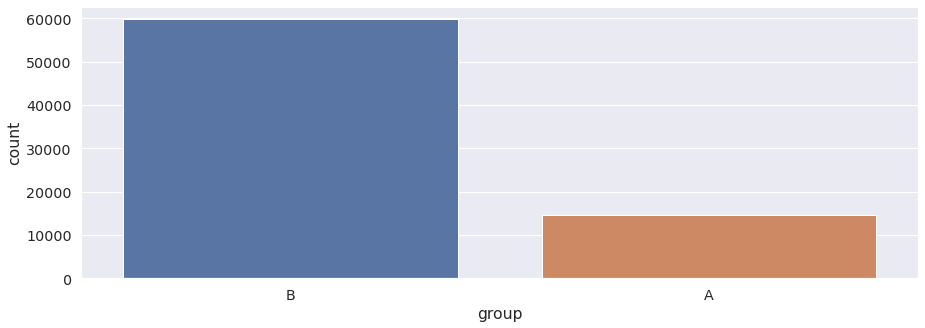

In [124]:
#Визуализируем распределение по группам. Видим, что оно неравномерное
sns.countplot(data = complete_df, x='group')
complete_df['group'].value_counts(normalize=True)

# Подготовка для статистического исследования

In [125]:
#Оставляем только активных пользователей
active_users = complete_df.loc[complete_df['activity'] == True]

In [126]:
#Пользователи, оплатившие курс, в обеих группах
complete_paid = active_users.loc[active_users['revenue'] > 0]

In [127]:
#Активные пользователи из группы А
A_group =  active_users.loc[active_users['group'] == "A"]

In [128]:
#Пользователи из группы А, оплатившие курс
A_group_paid = A_group.loc[A_group['revenue'] > 0]

In [129]:
#Активные пользователи из группы B
B_group =  active_users.loc[active_users['group'] == "B"]

In [130]:
#Пользователи из группы B, оплатившие курс
B_group_paid = B_group.loc[B_group['revenue'] > 0]

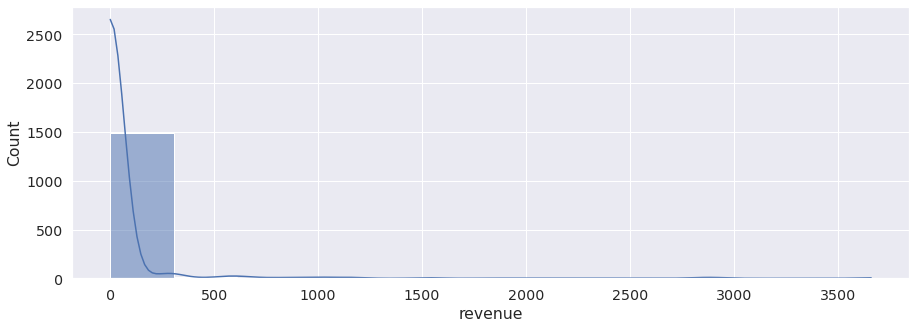

In [131]:
#Распределение активных пользователей группы  А
sns.histplot(data=A_group, x="revenue", kde=True)

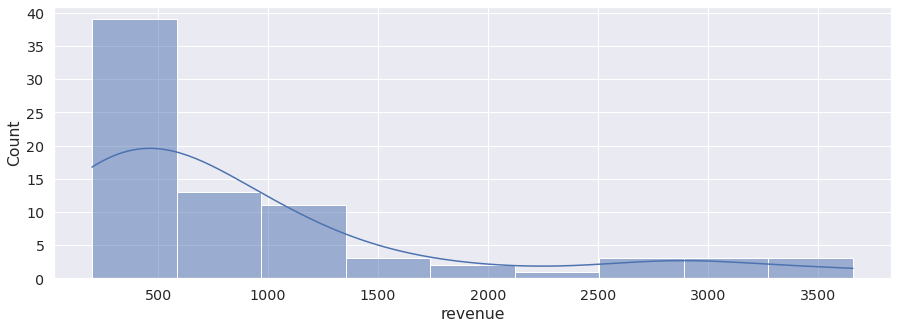

In [132]:
#Распределение пользователей, оплативших курс, из группы А
sns.histplot(data=A_group_paid, x="revenue", kde=True)

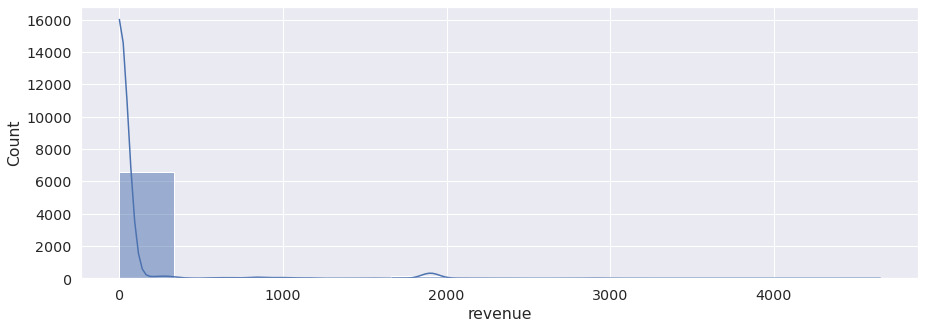

In [133]:
#Распределение активных пользователей группы B
sns.histplot(data=B_group, x="revenue", kde=True)

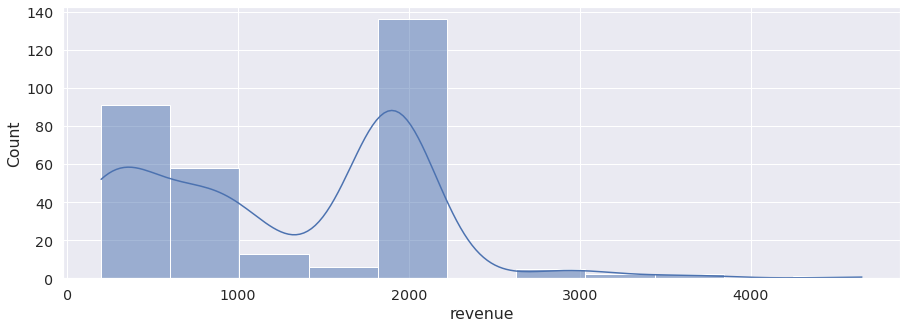

In [134]:
#Распределение пользователей, оплативших курс, из группы B
sns.histplot(data=B_group_paid, x="revenue", kde=True)

Распределения в группах не является нормальным, поэтому t-тест не подойдёт.


# Метрики

CR - Конверсия в покупку

ARPU - Общий доход / Количество пользователей за период. Средний доход с одного пользователя

ARPPU - Общий доход за период / Количество платящих пользователей за период.

Данных для этих метрик достаточно. Они наиболее адекватно отразят влияние изменения механики оплаты на группы.

In [135]:
#Посчитаем сколько всего пользователей в группе и общий доход каждой группы
metrics = active_users.groupby('group', as_index=False).agg({'revenue':'sum', 'id':'count'}).round(0)

In [136]:
#Сколько человек совершили покупку
metrics['buyers'] = active_users.loc[active_users['revenue'] > 0]\
    .groupby('group', as_index=False).agg({'id':'count'})['id']

In [137]:
#Считаем CR, ARPU и ARPPU
metrics['CR'] = (metrics['buyers']/metrics['id']).round(3)
metrics['ARPU'] = (metrics['revenue']/metrics['id']).round(3)
metrics['ARPPU'] = (metrics['revenue']/metrics['buyers']).round(3)
metrics

,group,revenue,id,buyers,CR,ARPU,ARPPU
0,A,72820.0,1538,78,0.051,47.347,933.590
1,B,394974.0,6803,314,0.046,58.059,1257.879


In [138]:
#эффект для CR
effect_CR = round((metrics.CR[1] - metrics.CR[0])/metrics.CR[0], 3)
'{:.1%}'.format(effect_CR)

'-9.8%'

In [139]:
#эффект для ARPU
effect_ARPU = round((metrics.ARPU[1] - metrics.ARPU[0])/metrics.ARPU[0], 3)
'{:.1%}'.format(effect_ARPU)

'22.6%'

In [140]:
#эффект для ARPPU
effect_ARPPU = round((metrics.ARPPU[1] - metrics.ARPPU[0])/metrics.ARPPU[0], 3)
'{:.1%}'.format(effect_ARPPU)

'34.7%'

В группе B конверсия снизилась на 9.8% в сравнении с группой A.

ARPU и ARPPU в группе B выросли на 22.6% и 34.7%, соответственно. 

Эти результаты сигнализируют об уменьшении количества продаж и увеличении их ценности в соотношении на 1 покупателя. Возможно, продукт стал менее привлекательным для части пользователей в виду его стоимости.

Проверим являются ли эти различия статистически значимыми?

# CR 

Для анализа CR применим ХИ-квадрат, так как он используется для анализа категориальных переменнных, а мы будем анализировать факт покупки в соответствии с принадлежностью к той или иной группе.

Гипотезы:

H0 - значение CR не зависит от группы

H1 - значение CR зависит от группы

In [141]:
#Создаем таблицу сопряженности, чтобы выявить взаимосвязь между двумя переменными
chi_2 = active_users.groupby(['group', 'payment'], as_index=False)\
                        .agg({'id': 'count'}) \
                        .pivot(values='id', index='payment', columns='group')
chi_2

group,A,B
payment,,
0,1460,6489
1,78,314


In [142]:
chi2_contingency(chi_2)[1]

0.48625240457231045

P-value, больше 0.05, значит мы не можем отклонить нулевую гипотезу 

Для анализа ARPU и ARPPU применим bootstrap.

Следует проверить, попадает ли 0 в доверительный интервал. Если да, то нулевая гипотеза принимается, если нет - отклоняется.

# ARPU


H0 - ARPU в двух группах одинаковые

H1 - ARPU в двух группах имеют различия

In [143]:
#Функция для бутстрапа
def bootstrap_(data, n_bootstrap=1000, statistic=np.mean):
    bootstrap_stats = []
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        stat = statistic(bootstrap_sample)
        bootstrap_stats.append(stat)
    return bootstrap_stats

In [147]:
bootstrap_ARPU_A = bootstrap_(A_group.revenue)
bootstrap_ARPU_B = bootstrap_(B_group.revenue)

#Рассчитываем доверительные интервалы
confidence_interval_ARPU_A = np.percentile(bootstrap_ARPU_A, [2.5, 97.5])
confidence_interval_ARPU_B = np.percentile(bootstrap_ARPU_B, [2.5, 97.5])

print("Доверительный интервал для группы A:", confidence_interval_ARPU_A)
print("Доверительный интервал для группы B:", confidence_interval_ARPU_B)

Доверительный интервал для группы A: [34.12797464 62.79092978]
Доверительный интервал для группы B: [50.74615658 65.64232759]


In [148]:
#Средние значения ARPU для группы A и группы B
mean_ARPU_A = np.mean(bootstrap_ARPU_A)
mean_ARPU_B = np.mean(bootstrap_ARPU_B)

#Расчет разницы между средними значениями ARPU
difference_ARPU = mean_ARPU_B - mean_ARPU_A

print("Среднее ARPU для группы A:", mean_ARPU_A)
print("Среднее ARPU для группы B:", mean_ARPU_B)
print("Разница между ARPU для группы B и группы A:", difference_ARPU)

Среднее ARPU для группы A: 47.388092977893365
Среднее ARPU для группы B: 57.988181761766874
Разница между ARPU для группы B и группы A: 10.60008878387351


In [149]:
#Разница между средними значениями ARPU для группы A и группы B
difference_ARPU = mean_ARPU_B - mean_ARPU_A

#Расчет стандартного отклонения разницы ARPU
std_dev_ARPU_diff = np.sqrt(np.var(bootstrap_ARPU_A) + np.var(bootstrap_ARPU_B))

#Расчет доверительного интервала для разницы ARPU
confidence_interval_ARPU_diff = [difference_ARPU - 1.96 * std_dev_ARPU_diff, difference_ARPU + 1.96 * std_dev_ARPU_diff]

print("Доверительный интервал для разницы ARPU:", confidence_interval_ARPU_diff)

Доверительный интервал для разницы ARPU: [-6.029950583357433, 27.230128151104452]


Доверительный интервал включает в себя значение "0", следовательно отклонить нулевую гипотезу мы не можем.


# ARPPU 

H0 - ARPPU в двух группах одинаковые

H1 - ARPPU в двух группах имеют различия

In [150]:
bootstrap_ARPPU_A = bootstrap_(A_group_paid.revenue)
bootstrap_ARPPU_B = bootstrap_(B_group_paid.revenue)

#Рассчитываем доверительные интервалы
confidence_interval_ARPPU_A = np.percentile(bootstrap_ARPPU_A, [2.5, 97.5])
confidence_interval_ARPPU_B = np.percentile(bootstrap_ARPPU_B, [2.5, 97.5])

print("Доверительный интервал для группы A:", confidence_interval_ARPPU_A)
print("Доверительный интервал для группы B:", confidence_interval_ARPPU_B)

Доверительный интервал для группы A: [ 739.96570513 1134.15737179]
Доверительный интервал для группы B: [1173.13225757 1348.67540809]


In [151]:
#Средние значения ARPPU для группы A и группы B
mean_ARPPU_A = np.mean(bootstrap_ARPPU_A)
mean_ARPPU_B = np.mean(bootstrap_ARPPU_B)

#Расчет разницы между средними значениями ARPPU
difference_ARPPU = mean_ARPPU_B - mean_ARPPU_A

print("Среднее ARPU для группы A:", mean_ARPPU_A)
print("Среднее ARPU для группы B:", mean_ARPPU_B)
print("Разница между ARPU для группы B и группы A:", difference_ARPPU)

Среднее ARPU для группы A: 934.7591666666667
Среднее ARPU для группы B: 1257.5010621226115
Разница между ARPU для группы B и группы A: 322.7418954559448


In [152]:
#Разница между средними значениями ARPPU для группы A и группы B
difference_ARPPU = mean_ARPPU_B - mean_ARPPU_A

#Расчет стандартного отклонения разницы ARPPU
std_dev_ARPPU_diff = np.sqrt(np.var(bootstrap_ARPPU_A) + np.var(bootstrap_ARPPU_B))

#Расчет доверительного интервала для разницы ARPPU
confidence_interval_ARPPU_diff = [difference_ARPPU - 1.96 * std_dev_ARPPU_diff, difference_ARPPU + 1.96 * std_dev_ARPPU_diff]

print("Доверительный интервал для разницы ARPPU:", confidence_interval_ARPPU_diff)

Доверительный интервал для разницы ARPPU: [105.40060017130969, 540.08319074058]


Доверительный интервал не включает в себя "0", следовательно мы отклоням нулевую гипотезу и делаем вывод о том, что ARPPU в двух группах различаются.

Ответ на вопрос бизнеса, необходима ли новая механика для всех пользователей: скорее да. Предлагаемая механика оплаты даёт статистически значимый прирост исходя из исследования метрики ARPPU. При этом CR статистически незначимо снизилась, а ARPU статистически незначимо выросла.

# Задание №2

2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица default.peas:

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

В данной таблице последний месяц - октрябрь 2021 года, его и принимаем за текущий.

In [71]:
#Подключение к ClickHouse
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [72]:
#Запрос из clickhouse в pandas dataframe. Текущий месяц - послений месяц в датафрейме.
query_1 = '''
    SELECT
        COUNT(st_id) AS stud
    FROM
        (SELECT 
            st_id,
            SUM(correct) as cor
        FROM peas
        WHERE timest::DATE >= '2021-10-01' and timest::DATE < '2021-11-01' and correct = 1
        GROUP BY st_id
        HAVING cor >= 20)
'''

In [73]:
#Результат в виде DataFrame
result_1 = ph.read_clickhouse(query=query_1, connection=connection_default)
result_1

,stud
0,136


Ответ: 136 усердных учеников.

2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:

In [74]:
#Запрос из clickhouse в pandas dataframe.
query_2 = '''
    SELECT 
        test_grp as grp,
        round(SUM(fcp.money)/uniqExact(s.st_id),4) as ARPU,
        round(SUMIf(fcp.money, query_in.act > 10)/uniqIf(s.st_id, query_in.act > 10),4) as ARPAU,
        round(uniqIf(s.st_id, fcp.money > 0)/uniqExact(s.st_id), 4) as CR,
        round(uniqIf(s.st_id, query_in.act > 10 and fcp.money > 0)/uniqIf(s.st_id, query_in.act > 10),4) as CR_active,
        round(uniqIf(s.st_id, query_in.math_active >= 2 and fcp.subject = 'Math' and fcp.money > 0) /
              uniqIf(s.st_id, query_in.math_active >= 2), 4) as CR_math
    FROM 
        studs s
    LEFT JOIN final_project_check fcp
        ON s.st_id = fcp.st_id
    LEFT JOIN (
            SELECT 
                st_id, 
                SUM(correct) as act, 
                SUMIf(correct, subject = 'Math') as math_active
            FROM 
                peas
            GROUP BY 
                st_id) as query_in 
    ON s.st_id = query_in.st_id

    GROUP BY test_grp

'''

In [75]:
#Выводим результат 
result_2 = ph.read_clickhouse(query=query_2, connection=connection_default)
result_2

,grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.9836,10393.7008,0.0492,0.1102,0.0612
1,pilot,11508.4746,29739.5833,0.1085,0.2604,0.0952


# Задание №3


3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [76]:
#Загрузим данные
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

public_key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 
final_url = base_url + urlencode(dict(public_key=public_key)) 
groups = pd.read_csv(requests.get(final_url).json()['href'], sep=';')

public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
final_url = base_url + urlencode(dict(public_key=public_key)) 
groups_add = pd.read_csv(requests.get(final_url).json()['href'])

public_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' 
final_url = base_url + urlencode(dict(public_key=public_key)) 
active_studs = pd.read_csv(requests.get(final_url).json()['href'])

public_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' 
final_url = base_url + urlencode(dict(public_key=public_key)) 
checks = pd.read_csv(requests.get(final_url).json()['href'], sep=';')
    

In [77]:
#Добавляем в функцию 4 аргумента
def updater(groups, groups_add, active_studs, checks):
    
    #Объединяем первые два датасета
    complete_groups = pd.concat([groups, groups_add], ignore_index=True)
    
    #Меняем названия в колонках, для успешного объединения
    active_studs = active_studs.rename(columns={'student_id' : 'id'})
    checks = checks.rename(columns={'student_id' : 'id'})

    #Мёрджим к полученному датасету данные об активных пользователях
    complete_groups_active = complete_groups.merge(active_studs.rename(columns={'id':'activity'}), left_on='id', right_on='activity', how='left')
    
    #Заменяем "NaN" нулями 
    complete_groups_active['activity'] = complete_groups_active.activity.fillna(0)
    
    #Приведем данные колонки 'activity' к типу bool
    complete_groups_active['activity'] = complete_groups_active.apply(lambda row: True if row['activity'] > 0 else False, axis=1)

    complete_df = complete_groups_active.merge(checks, on='id', how='left')

    #Заменяем NaN нулями в колонке 'rev'
    complete_df['rev'] = complete_df.rev.fillna(0)

    #Удаляем из датасета ошибочные данные 
    complete_df = complete_df.drop(complete_df[(complete_df.activity == False) & (complete_df.rev > 0 )].index)
    
    #Создаем новую колонку, отражающую статус покупки
    complete_df['payment'] = complete_df.rev.apply(lambda x: 0 if x == 0 else 1)
    
    #Оставляем только активных пользователей
    active_users = complete_df.loc[complete_df['activity'] == True]
    
    #Активные пользователи из группы А
    A_group =  active_users.loc[active_users['grp'] == "A"]
    #Пользователи из группы А, оплатившие курс
    A_group_paid = A_group.loc[A_group['rev'] > 0]
    
    #Активные пользователи из группы B
    B_group =  active_users.loc[active_users['grp'] == "B"]
    #Пользователи из группы B, оплатившие курс
    B_group_paid = B_group.loc[B_group['rev'] > 0]
        
    #Посчитаем сколько всего пользователей в группе и общий доход каждой группы
    metrics = active_users.groupby('grp', as_index=False).agg({'rev':'sum', 'id':'count'}).round(0)
    #Сколько человек совершили покупку
    metrics['buyers'] = active_users.loc[active_users['rev'] > 0].groupby('grp', as_index=False).agg({'id':'count'})['id']
    #Считаем CR, ARPU и ARPPU
    metrics['CR'] = (metrics['buyers']/metrics['id']).round(3)
    metrics['ARPU'] = (metrics['rev']/metrics['id']).round(3)
    metrics['ARPPU'] = (metrics['rev']/metrics['buyers']).round(3)
    
    return(metrics)

In [78]:
metrics = updater(groups, groups_add, active_studs, checks)
metrics

,grp,rev,id,buyers,CR,ARPU,ARPPU
0,A,72820.0,1538,78,0.051,47.347,933.590
1,B,394974.0,6803,314,0.046,58.059,1257.879


In [79]:
#Функция для построения графиков
def graph_maker(metrics):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    fig.tight_layout(h_pad=4)
    
    ax_CR = sns.barplot(data=metrics, x='grp', y='CR', ax=ax[0], palette=['#87CEFA', '#FFFACD']).set_title('Conversion Rate')
    ax_ARPU = sns.barplot(data=metrics, x='grp', y='ARPU', ax=ax[1], palette=['#87CEFA', '#FFFACD']).set_title('Average Revenue per User')
    ax_ARPPU = sns.barplot(data=metrics, x='grp', y='ARPPU', ax=ax[2], palette=['#87CEFA', '#FFFACD']).set_title('Average Revenue per Paying User')

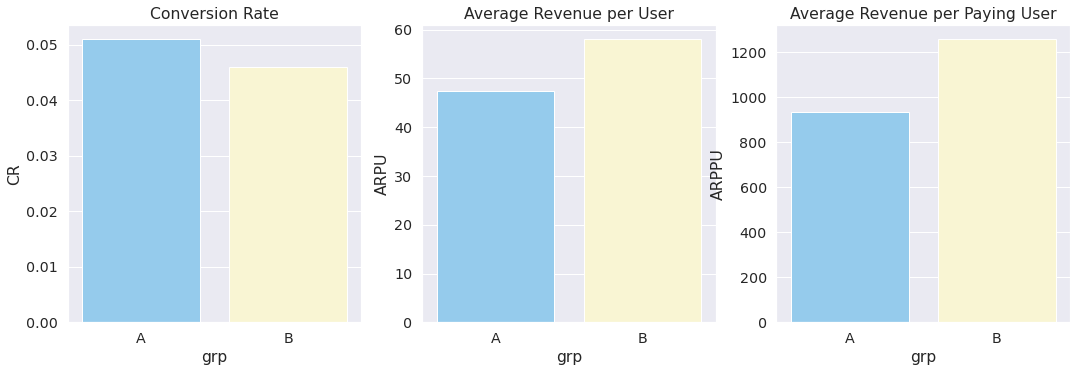

In [80]:
graph_maker(metrics)